In [1]:

from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


In [2]:
#Unziping the uploaded archive.zip

import zipfile
import os

zip_path = '/content/archive.zip'
extract_path = '/content/fer2013_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)
print("Contents:", os.listdir(extract_path))

Files extracted to: /content/fer2013_dataset
Contents: ['test', 'train']


In [3]:
train_dir = os.path.join(extract_path, 'train')
val_dir = os.path.join(extract_path, 'validation')
test_dir = os.path.join(extract_path, 'test')

In [4]:
#import libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import random

In [7]:
#data transforms and dataLoaders
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(48, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

emotion_labels = sorted(os.listdir(train_dir))

train_set = datasets.ImageFolder(train_dir, transform=train_transform)
test_set = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

In [8]:
#CNN model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*12*12, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=len(emotion_labels)).to(device)



In [9]:
# 5. Training model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/15, Loss: 1.6010
Epoch 2/15, Loss: 1.3803
Epoch 3/15, Loss: 1.3094
Epoch 4/15, Loss: 1.2546
Epoch 5/15, Loss: 1.2276
Epoch 6/15, Loss: 1.2014
Epoch 7/15, Loss: 1.1733
Epoch 8/15, Loss: 1.1653
Epoch 9/15, Loss: 1.1426
Epoch 10/15, Loss: 1.1250
Epoch 11/15, Loss: 1.1097
Epoch 12/15, Loss: 1.0994
Epoch 13/15, Loss: 1.0882
Epoch 14/15, Loss: 1.0732
Epoch 15/15, Loss: 1.0698


Test Accuracy: 0.621


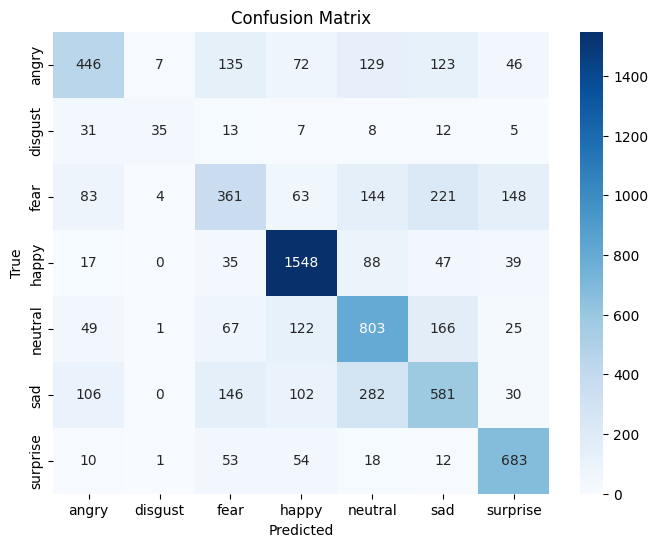

In [11]:
#test set evaluation and confusion matrix
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {acc:.3f}')

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

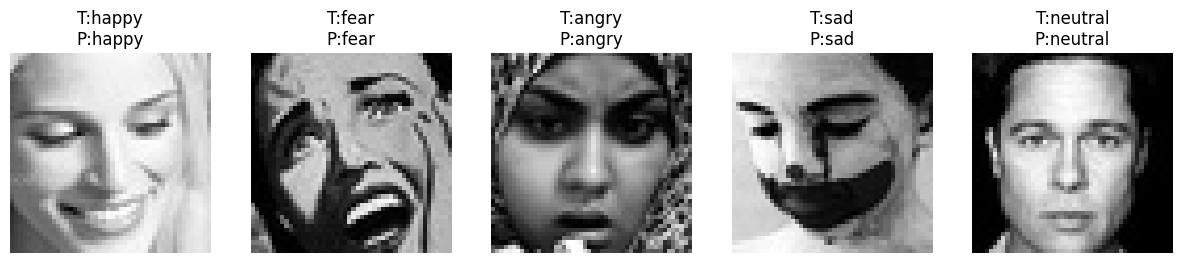

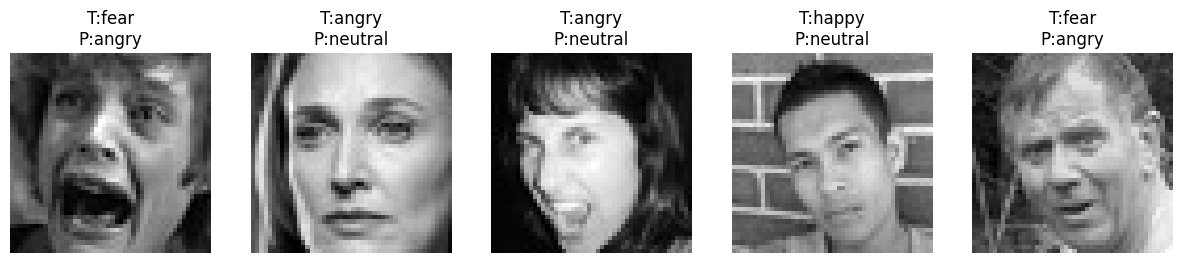

In [12]:
#Visualizing correct and incorrect predictions
def show_examples(indices, title):
    n = len(indices)
    fig, axes = plt.subplots(1, n, figsize=(n*3, 3))
    for i, idx in enumerate(indices):
        img, _ = test_set[idx]
        axes[i].imshow(img.squeeze(0).numpy()*0.5 + 0.5, cmap='gray')
        axes[i].set_title(title(idx))
        axes[i].axis('off')
    plt.show()

correct = [i for i in range(len(test_set)) if all_preds[i] == all_labels[i]]
incorrect = [i for i in range(len(test_set)) if all_preds[i] != all_labels[i]]

show_examples(random.sample(correct, 5), lambda idx: f"T:{emotion_labels[all_labels[idx]]}\nP:{emotion_labels[all_preds[idx]]}")
show_examples(random.sample(incorrect, 5), lambda idx: f"T:{emotion_labels[all_labels[idx]]}\nP:{emotion_labels[all_preds[idx]]}")